### setup

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../src/')
from video_tools import *
from image_tools import *
from notebook_tools import *

In [3]:
%load_ext autoreload
%autoreload 1
%aimport video_tools
%aimport image_tools
%aimport notebook_tools

In [4]:
# normal size plots
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (6,6)

In [5]:
video = '../test/Game_20210408T225110.avi'
# video = '../vid_out/Game_20210407T150943.avi'
frame = grab_frame(200, video)

In [6]:
mask = np.load('./manual_mask.npy')

### showcasing filters

In [7]:
def identity(img):
    return img

def mask_wrapper(callback):
    return lambda img: callback(apply_mask(img, mask))

def blur_mask_wrapper(callback):
    return lambda img: callback(apply_mask_blur(img, mask))

def merge_sobel_canny(img):
    return merge(sobel_edge(img), canny_edge(img))

def find_and_draw_keypoints(img):
    pts = find_keypoints(img)
    return draw_pts(img.copy(), pts)

def mask_around_keypoints(img):
    pts = find_keypoints(img)
    masked_around = mask_patches_around_pts(img, pts)
    return draw_pts(masked_around, pts)

def keypoints_on_just_y(img):
    y = split_channels(to_ycrcb(img))[0]
    rgb = to_3channels(y)
    pts = find_keypoints(rgb)
    return draw_pts(rgb, pts)

def white_keypoints(img):
    pts = find_keypoints(img)
    return pts_on_black(pts, img.shape)
    
def white_patches(img):
    pts = find_keypoints(img)
    return patches_around_pts_on_black(pts, img.shape)


In [8]:
filters = [
    identity,
    reduce_colors,
    canny_edge,
    sobel_edge,
    lambda img: merge(canny_edge(img), sobel_edge(img)),
    lambda img: gradients(img, axis=0),
    lambda img: threshold(gradients(img, axis=0), 10),
    lambda img: gradients(img, axis=1),
    lambda img: threshold(gradients(img, axis=1), 10),
    lambda img: merge(gradients(img, axis=0), gradients(img, axis=1)),
    find_and_draw_keypoints,
    mask_around_keypoints,
    white_keypoints,
    white_patches,
    lambda img: threshold(gradients(img, axis=1), 10) & threshold(gradients(img, axis=0), 10),
]

filters = [resize_wrapper(blur_mask_wrapper(f)) for f in filters]
filters.insert(0, identity)  # plain first example, not resized or masked

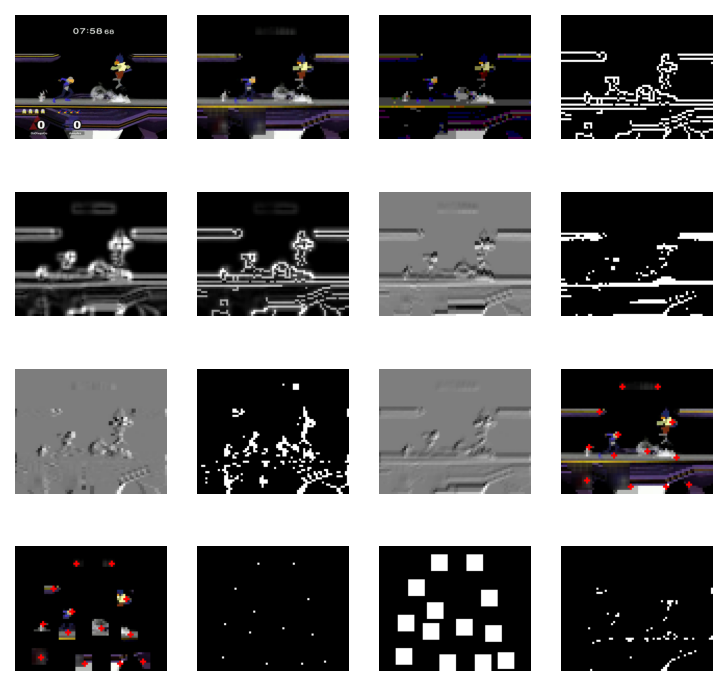

In [9]:
imshow(*[ f(frame) for f in filters ])

In [39]:
# for f in filters:
#     filter_playback(video, f)

# filter_playback(video, resize_wrapper(mask_wrapper(white_keypoints)))
filter_playback(video, resize_wrapper(mask_wrapper(find_and_draw_keypoints)))

### showcasing many images

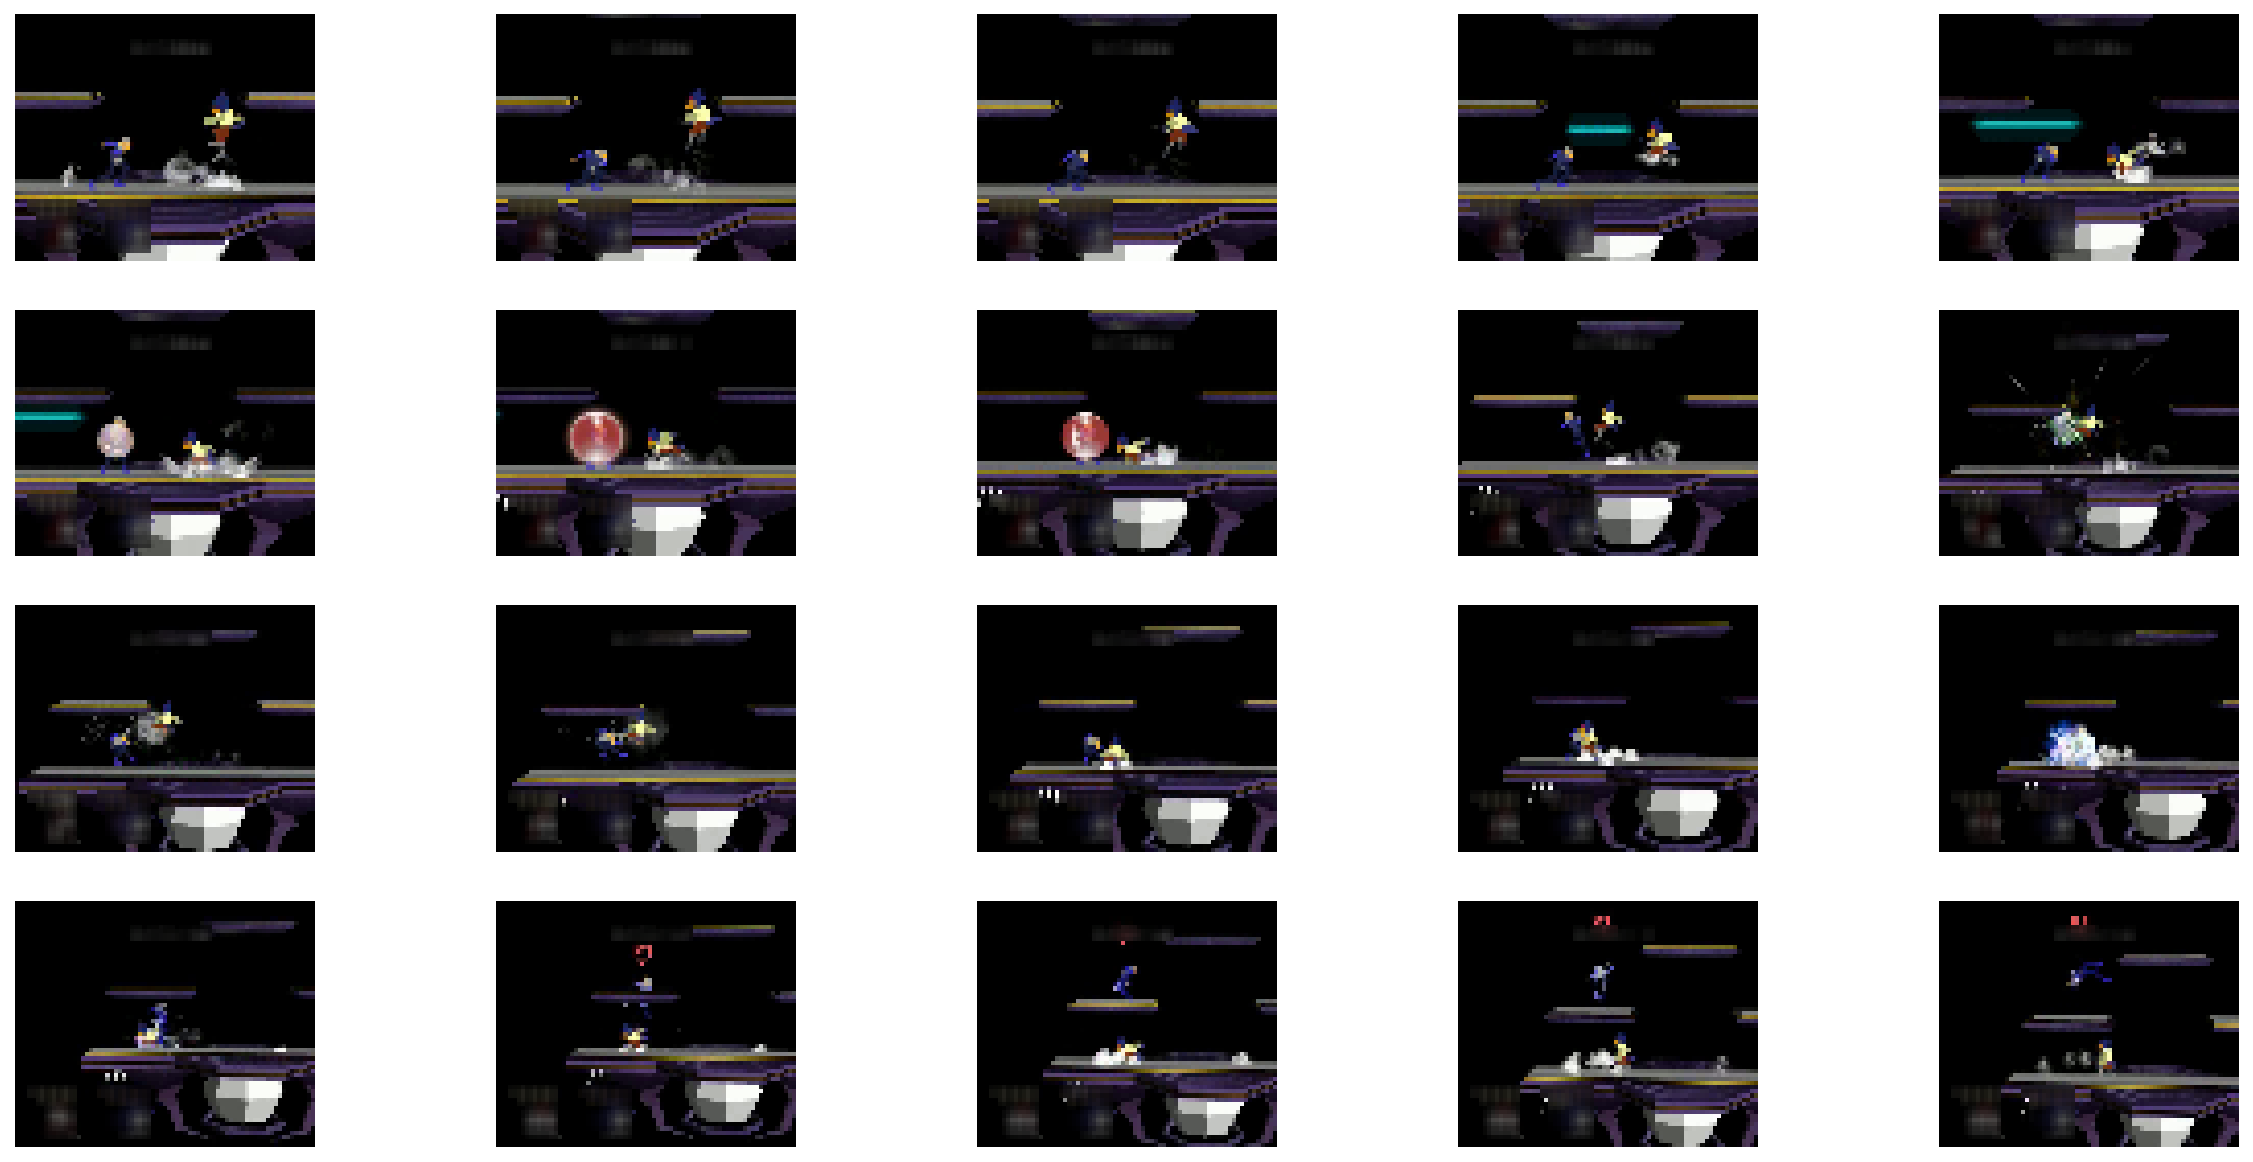

In [12]:
plt.rcParams['figure.figsize'] = (20,10)

imshow(*[
    apply_mask_blur(downscale_max_to_min_res(frame), mask)
    for frame in range_of_frames(video, range(200,300,5))
])

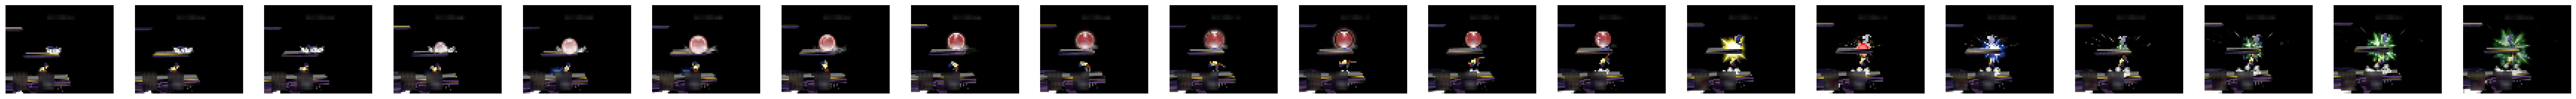

In [13]:
frames = [
    apply_mask_blur(downscale_max_to_min_res(frame), mask)
    for frame in range_of_frames(video, range(1000, 1020))
]

plt.rcParams['figure.figsize'] = (60,5)
plot_a_lot(frames, imshow_bgr2rgb, nrows=1)

In [14]:
plt.rcParams['figure.figsize'] = (4,4) # back to normal for others